In [26]:
import sys
sys.path.insert(0,'..')

In [27]:
import torch
import numpy as np

import priors
from train import train, get_weighted_single_eval_pos_sampler
import encoders
import positional_encodings
import utils
import bar_distribution
import decoders
from datasets import *
import os

from tqdm import tqdm
import time

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyro.distributions as dist

import torch.nn as nn
import os.path
import glob

from mcmc_svi_transformer_on_bayesian import get_model, get_default_model_spec, generate_toy_data, load_results, plot_with_confidence_intervals, training_steps, training_samples, get_default_evaluation_points, compute_mean_and_conf_interval, eval_transformer
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro


In [3]:
%load_ext autoreload

%autoreload 2

In [82]:
## DEFINE A PRIOR MODEL ##
# We define a Bayesian Model as a prior for all methods
# This can be replaced by other models that inherit from PyroModule.
class BayesianModel(PyroModule):
    def __init__(self, model_spec, device='cuda'):
        super().__init__()

        self.device = device
        self.num_features = model_spec['num_features']

        mu, sigma = torch.tensor([0.0]).to(self.device), torch.tensor([1.0]).to(self.device)

        self.fc1 = PyroModule[nn.Linear](self.num_features, model_spec['embed'])
        self.fc1.weight = PyroSample(
            dist.Normal(mu, sigma).expand([model_spec['embed'], self.num_features]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(mu, sigma).expand([model_spec['embed']]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](model_spec['embed'], 2)
        self.fc2.weight = PyroSample(dist.Normal(mu, sigma).expand([2, model_spec['embed']]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(mu, sigma).expand([2]).to_event(1))

        self.model = torch.nn.Sequential(self.fc1, self.fc2)

        self.to(self.device)

    def forward(self, x=None, y=None, seq_len=1):
        if x is None:
            with pyro.plate("x_plate", seq_len):
                d_ = dist.Normal(torch.tensor([0.0]).to(self.device), torch.tensor([1.0]).to(self.device)).expand(
                    [self.num_features]).to_event(1) # sample uniformly from unit cube
                x = pyro.sample("x", d_)

        out = self.model(x) # [seq_len,feature]
        mu = out.squeeze() # [seq_len,feature]
        softmax = torch.nn.Softmax(dim=1)
        with pyro.plate("data", out.shape[0]):
            s = softmax(mu) # [seq_len,feature]
            obs = pyro.sample('obs', dist.Categorical(probs=s), obs=y).float() # doing categoration, here 0 or 1

        return x, obs

In [5]:
results_directory = '../results' # Where to save results
model_spec_size = 'small' # Size of the BNN model to evaluate, also try big
bptt = 100 # Number of samples in each dataset

# Training samples seen after which to evaluate the methods
evaluation_points = [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92]
model_spec = get_default_model_spec(model_spec_size)

# Function which generates a model from the prior
model_sampler = lambda : BayesianModel(model_spec, device = device)

global_results = {} # Dict in which to save results
task = 'samples' # Task to evaluate, only option is samples, keep fixed

In [6]:
!mkdir {results_directory}

mkdir: cannot create directory ‘../results’: File exists


### Evaluate SVI and MCMC

In [36]:
method = 'mcmc'
steps = 1
device = 'cpu'
path_interfix = f'{results_directory}/timing_{model_spec_size}_model_test'

In [83]:
test_model = model_sampler()

In [38]:
!mkdir {path_interfix}

mkdir: cannot create directory ‘../results/timing_small_model_test’: File exists


In [ ]:
# This evaluates baseline method (SVI or MCMC) with varying number of trainings samples and steps number of inference steps

X, y = generate_toy_data(test_model, bptt, device) 
# X.shape:[100,100,3](num_of_datasets,num_of_points_in_each_dataset,feature) Y.shape:[100,100]

training_samples(method
                 , X
                 , y
                 , model_sampler
                 , evaluation_points
                 , steps=steps
                 , device=device
                 , path_interfix=path_interfix)

  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]/home/ypq/anaconda3/envs/GD/lib/python3.9/site-packages/pyro/infer/mcmc/util.py:681: FutureWarning: The `mcmc.predictive` function is deprecated and will be removed in a future release. Use the `pyro.infer.Predictive` class instead.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.93it/s]


NLL  (41.908165, 3.1804894861157584)
ACC  (0.5809184, 0.03180489580730596)
TIME  4.180830001831055


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.84it/s]


NLL  (31.784946, 2.730332338095458)
ACC  (0.6821506, 0.02730331995116673)
TIME  5.9410645961761475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.80it/s]


NLL  (25.52273, 2.4529806749615646)
ACC  (0.74477285, 0.024529807222689833)
TIME  6.332571744918823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.03it/s]


NLL  (25.24096, 2.46490025215726)
ACC  (0.7475902, 0.02464900269897542)
TIME  6.65488862991333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.59it/s]


NLL  (22.80769, 2.4198965155936243)
ACC  (0.77192307, 0.024198964268922145)
TIME  7.362050294876099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.74it/s]


NLL  (21.72603, 2.206853800414139)
ACC  (0.7827398, 0.022068536762321653)
TIME  7.854220151901245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.22it/s]


NLL  (22.838234, 2.5547731829859726)
ACC  (0.77161765, 0.025547732776008098)
TIME  7.571099519729614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.70it/s]


NLL  (20.25397, 2.0587970969643634)
ACC  (0.7974603, 0.020587966830244504)
TIME  7.876355171203613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.68it/s]


NLL  (19.810345, 2.228004190360798)
ACC  (0.8018965, 0.022280043795904727)
TIME  8.564610242843628


 16%|████████████████▋                                                                                       | 16/100 [00:01<00:07, 11.44it/s]

### Training Transformer on Prior (Skip this step to reuse results)

In [12]:
device = 'cpu'

In [13]:
config = {'lr': 2.006434218345026e-05
 , 'epochs': 160
 , 'dropout': 0.0
 , 'emsize': 256
 , 'batch_size': 256
 , 'nlayers': 5
 , 'num_outputs': 1
 , 'num_features': model_spec['num_features']
 , 'steps_per_epoch': 100
 , 'nhead': 4
 , 'seq_len': model_spec['seq_len']
 , 'nhid_factor': 2}

In [84]:
transformer_model = get_model(model_sampler, config, should_train = True)
model_path = os.path.join(results_directory, f'bayesian_models_transformer_checkpoint_{model_spec_size}_epochs_'+config['epochs']+'.cpkt')
torch.save((transformer_model[2].state_dict(), None), model_path)


Using cpu:0 device
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 256, 'seq_len': 300, 'num_outputs': 1, 'num_features': 3, 'canonical_args': None, 'model': <function <lambda> at 0x7fc4801af9d0>}, 'num_features': 3, 'num_outputs': 1}


KeyboardInterrupt: 

### Evaluating Transformer

In [85]:
loaded_epoch = config['epochs']
transformer_model = get_model(model_sampler, config, should_train = False)
path = os.path.join(results_directory, f'bayesian_models_transformer_checkpoint_{model_spec_size}_epochs_{loaded_epoch}.cpkt')
model_state, optimizer_state = torch.load(path)
transformer_model[2].load_state_dict(model_state)

Using cpu:0 device
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 256, 'seq_len': 300, 'num_outputs': 1, 'num_features': 3, 'canonical_args': None, 'model': <function <lambda> at 0x7fc4801af9d0>}, 'num_features': 3, 'num_outputs': 1}


<All keys matched successfully>

In [ ]:
X, y = generate_toy_data(test_model, bptt, device)

In [90]:
results_acc = []
results_nll = []
transformer_model[2].eval()
for training_samples_n in evaluation_points:
    print(training_samples_n)
    acc, nll, elapsed = eval_transformer(X, y, model=transformer_model[2], training_samples_n=training_samples_n, device=device)
    results_acc.append(acc)
    results_nll.append(nll)
mean = np.array([compute_mean_and_conf_interval(nll)[0] for nll in results_nll])
conf = np.array([compute_mean_and_conf_interval(nll)[1] for nll in results_nll])
global_results['transformer'] = (None, np.array(evaluation_points), mean, conf)


2
torch.Size([100])
torch.Size([100])
7
torch.Size([100])
torch.Size([100])
12
torch.Size([100])
torch.Size([100])
17
torch.Size([100])
torch.Size([100])
22
torch.Size([100])
torch.Size([100])
27


KeyboardInterrupt: 

## Plotting results

In [42]:
files, times, samples, mean, conf = load_results(f'{results_directory}/timing_{model_spec_size}_model_test/results_svi_1_training_{task}', task=task)
global_results['svi'] = (times/100, samples, mean, conf)
files, times, samples, mean, conf = load_results(f'{results_directory}/timing_{model_spec_size}_model_test/results_mcmc_1_training_{task}', task=task)
global_results['mcmc'] = (times/100, samples,mean, conf)


../results/timing_small_model_test/results_svi_1_training_samples_2.npy
../results/timing_small_model_test/results_svi_1_training_samples_7.npy
../results/timing_small_model_test/results_svi_1_training_samples_12.npy
../results/timing_small_model_test/results_svi_1_training_samples_17.npy
../results/timing_small_model_test/results_svi_1_training_samples_22.npy
../results/timing_small_model_test/results_svi_1_training_samples_27.npy
../results/timing_small_model_test/results_svi_1_training_samples_32.npy
../results/timing_small_model_test/results_svi_1_training_samples_37.npy
../results/timing_small_model_test/results_svi_1_training_samples_42.npy
../results/timing_small_model_test/results_svi_1_training_samples_47.npy
../results/timing_small_model_test/results_svi_1_training_samples_52.npy
../results/timing_small_model_test/results_svi_1_training_samples_57.npy
../results/timing_small_model_test/results_svi_1_training_samples_62.npy
../results/timing_small_model_test/results_svi_1_trai

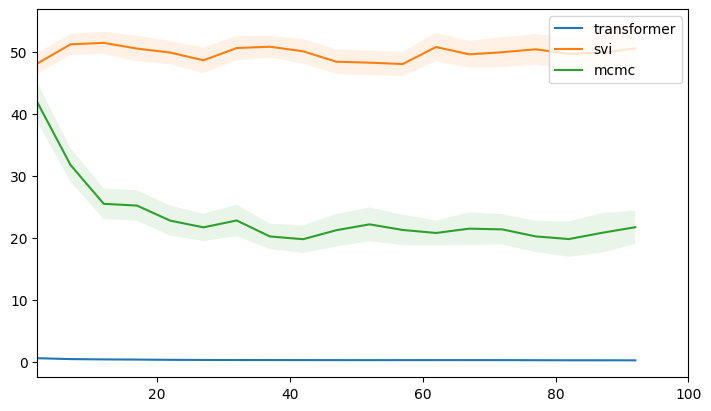

In [43]:
y_min = min([global_results[k][2].min() for k in global_results])
y_max = max([global_results[k][2].max() for k in global_results])

fig2 = plt.figure(constrained_layout=True, figsize=(7, 4))
axes = plt.axes()
axes.set_xlim(2, 100)
#axes.set_ylim(y_min, y_max)
for k in global_results:
    plot_with_confidence_intervals(plt, global_results[k][1], global_results[k][2], global_results[k][3], label=k)
    #plt.plot(global_results_train_steps[k][1], global_results_train_steps[k][0], label=k)
plt.legend(loc="upper right")